# Курсовая работа

Предсказание температуры в Сегеде

## Приступая к работе

### Импорты

In [91]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Загрузка датасета

In [68]:
df = pd.read_csv('data/weatherHistory.csv')

## Разведочный анализ данных

In [69]:
eda_df = df

### Общий вид

In [70]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [71]:
eda_df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


### Отбор признаков

Строковые признаки нам не нужны, а категориальные признаки мы превратим в бинарные. Как можно заметить в describe, Loud Cover всегда принимает значение 0, поэтому он тоже лишний.

In [72]:
eda_df.drop(['Formatted Date', 'Summary', 'Daily Summary', 'Loud Cover'], axis=1, inplace=True)
eda_df = pd.get_dummies(eda_df)
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (C)           96453 non-null  float64
 1   Apparent Temperature (C)  96453 non-null  float64
 2   Humidity                  96453 non-null  float64
 3   Wind Speed (km/h)         96453 non-null  float64
 4   Wind Bearing (degrees)    96453 non-null  float64
 5   Visibility (km)           96453 non-null  float64
 6   Pressure (millibars)      96453 non-null  float64
 7   Precip Type_rain          96453 non-null  uint8  
 8   Precip Type_snow          96453 non-null  uint8  
dtypes: float64(7), uint8(2)
memory usage: 5.3 MB


Для большей читаемости, переименуем признаки Recip Type, сократив их название. Также переименуем и остальные признаки, убрав подсказки в скобках

In [73]:
eda_df.rename(columns={
    'Precip Type_rain': 'Rainy',
    'Precip Type_snow': 'Snowy',
    'Temperature (C)': 'Temperature',
    'Apparent Temperature (C)': 'Apparent Temperature',
    'Wind Speed (km/h)': 'Wind Speed',
    'Wind Bearing (degrees)': 'Wind Bearing',
    'Visibility (km)': 'Visibility',
    'Pressure (millibars)': 'Pressure'
}, inplace=True)
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           96453 non-null  float64
 1   Apparent Temperature  96453 non-null  float64
 2   Humidity              96453 non-null  float64
 3   Wind Speed            96453 non-null  float64
 4   Wind Bearing          96453 non-null  float64
 5   Visibility            96453 non-null  float64
 6   Pressure              96453 non-null  float64
 7   Rainy                 96453 non-null  uint8  
 8   Snowy                 96453 non-null  uint8  
dtypes: float64(7), uint8(2)
memory usage: 5.3 MB


Красота!

### Корреляционный анализ

<AxesSubplot:>

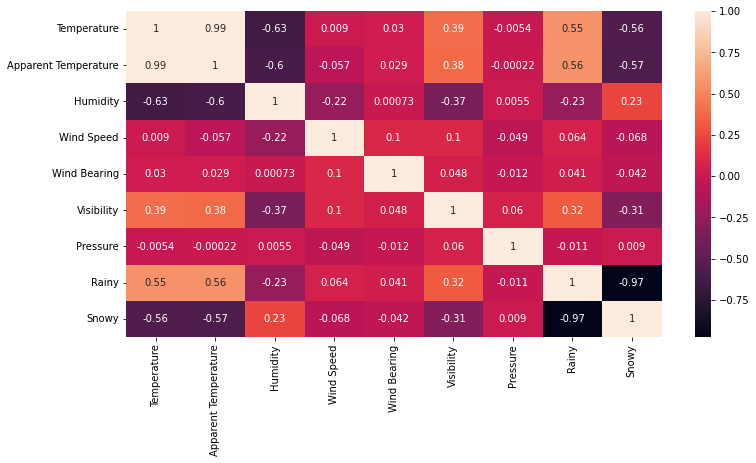

In [74]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)

corr_mat = eda_df.corr()
sns.heatmap(corr_mat, annot=True)

Можно увидеть сильную взаимосвязь между признаками __Temperature__ и __Apparent Temperature__

### Дисперсионный анализ

Возьмем два признака из корреляционного анализа и проверим, равны ли их средние значения. Для этого подберем выборку из 1000 наблюдений

In [75]:
sample = eda_df.sample(1000, random_state=21)
variance_a = stats.f_oneway(sample['Temperature'], sample['Apparent Temperature'])
variance_a

F_onewayResult(statistic=5.272395644418995, pvalue=0.02176924935244418)

In [76]:
print(f'Равны ли средние: {variance_a.pvalue > 0.05}')

Равны ли средние: False


Нулевая гипотеза о том, что средние значения в каждой выборке равны отвергается.

### Факторный анализ

Хоть средние и не равны, тем не менее эти признаки сильно взаимосвязаны, как нам показал корреляционный анализ. Для линейной модели регрессии плохо, когда она учится на двух похожих признаках, она может переобучиться. Это как если обучать ее одиними и теми же входными данными. Давайте объедими два признака в один используя метод главных компонент (PCA)

In [77]:
temperature_features = eda_df[['Temperature', 'Apparent Temperature']]
pca = PCA(n_components=1)
two_tempeatures = pca.fit_transform(temperature_features)
print(pca.explained_variance_ratio_)

[0.99636132]


Как можем заметить, если мы объединим два признака, мы потеряем совсем немного информации. Можно объединять

In [78]:
eda_df['Temperature'] = two_tempeatures
eda_df.drop('Apparent Temperature', axis=1, inplace=True)

### Нормальность распределения

Гипотезу будем проверять на выборке из дисперсионного анализа. Проверять будем температуру. Посмотрим на распределение визуально

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

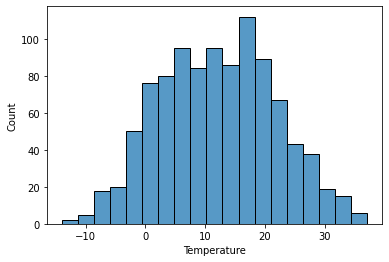

In [43]:
sns.histplot(x=sample['Temperature'])

Для проверки на нормальность распределения воспользуемся критерием Шапиро Уилка

In [41]:
stat, p = stats.shapiro(sample['Temperature'])
p > 0.05

False

Нулевая гипотеза опровергнута, значит значения не распределены нормально.

## Обучение

Разобьем данные на обучающую и валидационную выборку

In [80]:
X = eda_df.drop('Temperature', axis=1)
y = eda_df['Temperature']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

Обучим модель линейной регрессии предсказывать температуру

In [88]:
model = LinearRegression().fit(X_train, y_train)

Предскажем целевую переменную на валидационной выборке

In [86]:
y_pred = model.predict(X_valid)

### Метрики качества

Оценим качество обученной модели на тренировочной и валидационной выборке используя метрику $R^2$

In [93]:
print(f'Train: {r2_score(y_pred, y_valid)} \
\nValid: {r2_score(model.predict(X_train), y_train)}')

Train: 0.34575873408392777 
Valid: 0.35224910774282137


Качество линейной модели невысоко